In [23]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/user/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.signal import butter, filtfilt
import traceback

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/user/thesis_ws/src/ML/DATA/1D_FP_GRIP_NotNorm/'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

X_data shape: (1465, 800, 4)
y_data shape: (1465,)
X_data.[0] shape:  (800, 4)
TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800, 4)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800, 4)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800, 4)    ||  Dimensions of y_val:   (293,)


/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_147 (Conv1D)             │ (None, 77, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_98 (MaxPooling1D) │ (None, 38, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_34         │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5080 - loss: 0.6950 - val_accuracy: 0.5904 - val_loss: 0.6665
Epoch 2/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6154 - loss: 0.6597 - val_accuracy: 0.6143 - val_loss: 0.6220
Epoch 3/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6448 - loss: 0.5939 - val_accuracy: 0.6246 - val_loss: 0.6054
Epoch 4/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6423 - loss: 0.5960 - val_accuracy: 0.6348 - val_loss: 0.5909
Epoch 5/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6774 - loss: 0.5688 - val_accuracy: 0.6485 - val_loss: 0.5825
Epoch 6/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6915 - loss: 0.5502 - val_accuracy: 0.6553 - val_loss: 0.5691
Epoch 7/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6940 - loss: 0.5552 - val_accuracy: 0.6416 - val_loss: 0.5571
Epoch 8/78
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7168 - loss: 0.5278 - val_accuracy: 0.6724 - val_loss

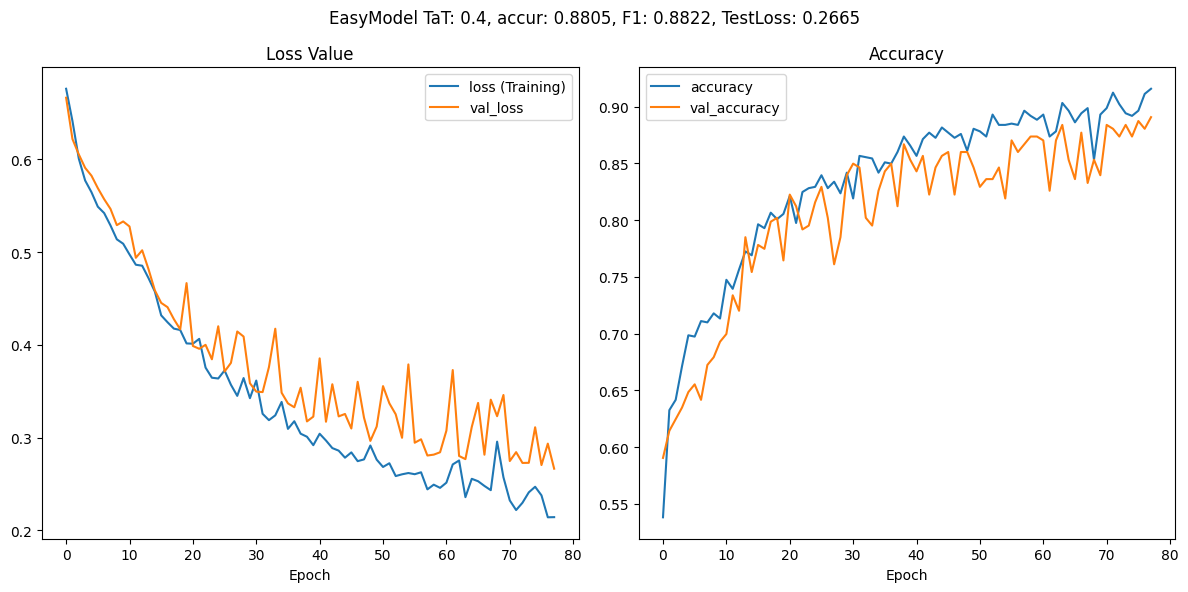

Train loss: 0.21430382132530212
Test val_loss: 0.2665451765060425
Train accuracy: 0.9158134460449219
Accuracy Score: 0.8805460750853242
F1 Score: 0.8821548821548821
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       138
         1.0       0.92      0.85      0.88       155

    accuracy                           0.88       293
   macro avg       0.88      0.88      0.88       293
weighted avg       0.88      0.88      0.88       293



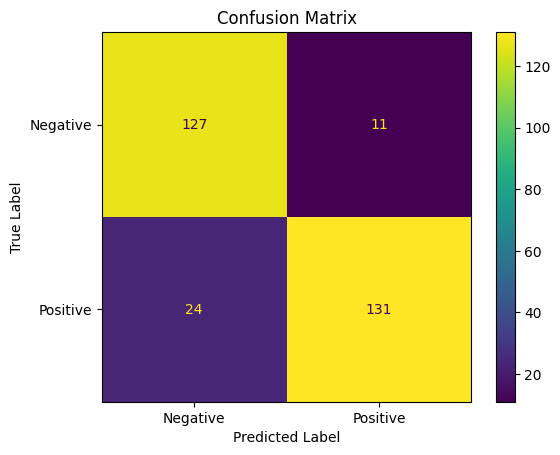

In [24]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', input_shape=(WS_B, 4)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalMaxPooling1D())
    # model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=78, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)

# STILL UNIQUE MODEL, Single BRANCH

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_148 (Conv1D)             │ (None, 77, 128)        │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_99 (MaxPooling1D) │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_149 (Conv1D)             │ (None, 15, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_100               │ (None, 7, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_150 (Conv1D)             │ (None, 2, 256)         │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_35         │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,929 (1.33 MB)

 Trainable params: 348,929 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.5538 - loss: 0.6975 - val_accuracy: 0.6041 - val_loss: 0.6757
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6361 - loss: 0.6535 - val_accuracy: 0.6451 - val_loss: 0.6680
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6520 - loss: 0.6412 - val_accuracy: 0.6485 - val_loss: 0.6093
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6680 - loss: 0.6107 - val_accuracy: 0.6826 - val_loss: 0.5566
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7489 - loss: 0.5272 - val_accuracy: 0.7065 - val_loss: 0.5035
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7370 - loss: 0.5021 - val_accuracy: 0.6758 - val_loss: 0.5789
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7106 - loss: 0.5277 - val_accuracy: 0.7679 - val_loss: 0.4839
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7848 - loss: 0.4492 - val_accuracy: 0.7372 - val_loss

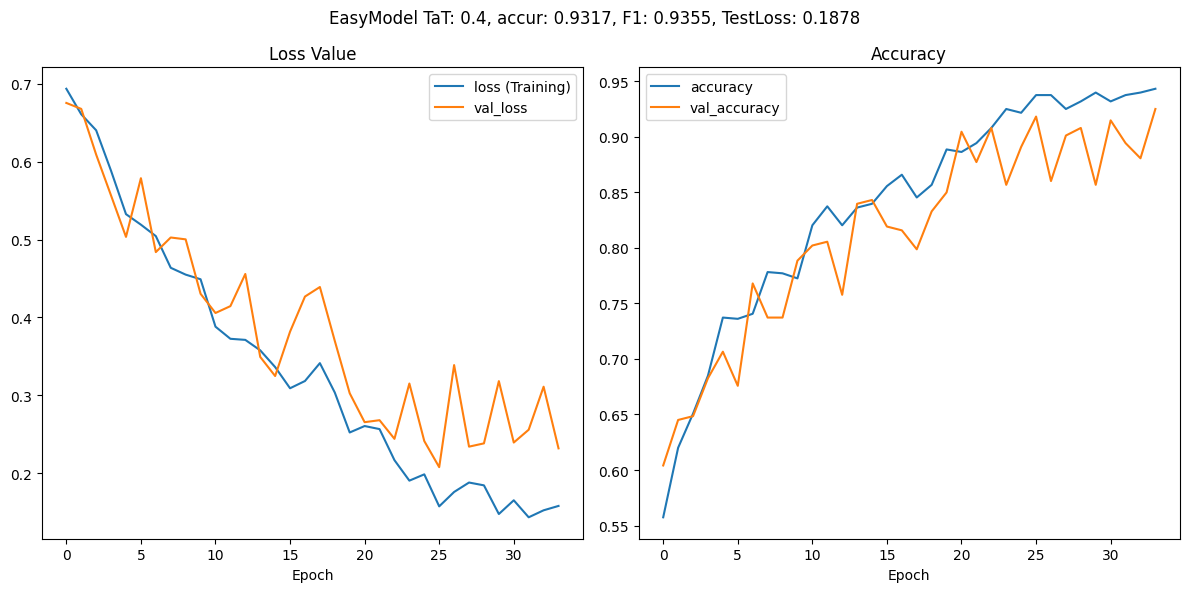

Train loss: 0.1577131450176239
Test val_loss: 0.23171330988407135
Train accuracy: 0.9431172013282776
Accuracy Score: 0.931740614334471
F1 Score: 0.9354838709677419
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       138
         1.0       0.94      0.94      0.94       155

    accuracy                           0.93       293
   macro avg       0.93      0.93      0.93       293
weighted avg       0.93      0.93      0.93       293



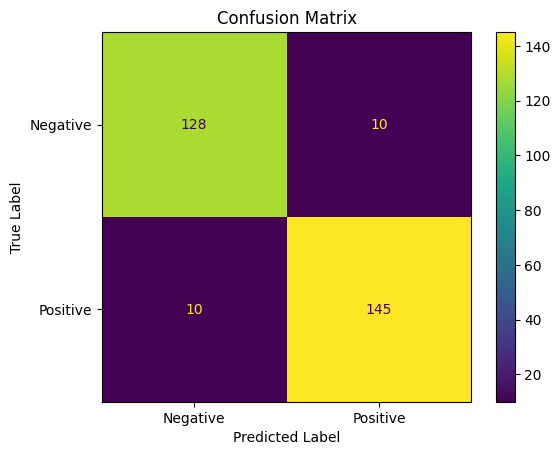

In [25]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=40, strides=10, activation='relu', input_shape=(WS_B, 4)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=10, strides=2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=4,strides=2, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid')) # activation=(lambda x: x>0)
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)

# SINGLE BRANCH, 5 LAYERS

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_151 (Conv1D)             │ (None, 77, 128)        │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_101               │ (None, 38, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_152 (Conv1D)             │ (None, 16, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_102               │ (None, 8, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_153 (Conv1D)             │ (None, 5, 128)         │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_103               │ (None, 2, 128)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_154 (Conv1D)             │ (None, 1, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_36         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,689 (1010.50 KB)

 Trainable params: 258,689 (1010.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5340 - loss: 0.6833 - val_accuracy: 0.6621 - val_loss: 0.6424
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6000 - loss: 0.6637 - val_accuracy: 0.6655 - val_loss: 0.6179
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6208 - loss: 0.6460 - val_accuracy: 0.6724 - val_loss: 0.5962
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6581 - loss: 0.6068 - val_accuracy: 0.6519 - val_loss: 0.5786
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7035 - loss: 0.5666 - val_accuracy: 0.7031 - val_loss: 0.5204
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7142 - loss: 0.5613 - val_accuracy: 0.7440 - val_loss: 0.5008
Epoch 7/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7598 - loss: 0.4956 - val_accuracy: 0.6758 - val_loss: 0.5831
Epoch 8/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7631 - loss: 0.5125 - val_accuracy: 0.7577 - val_loss

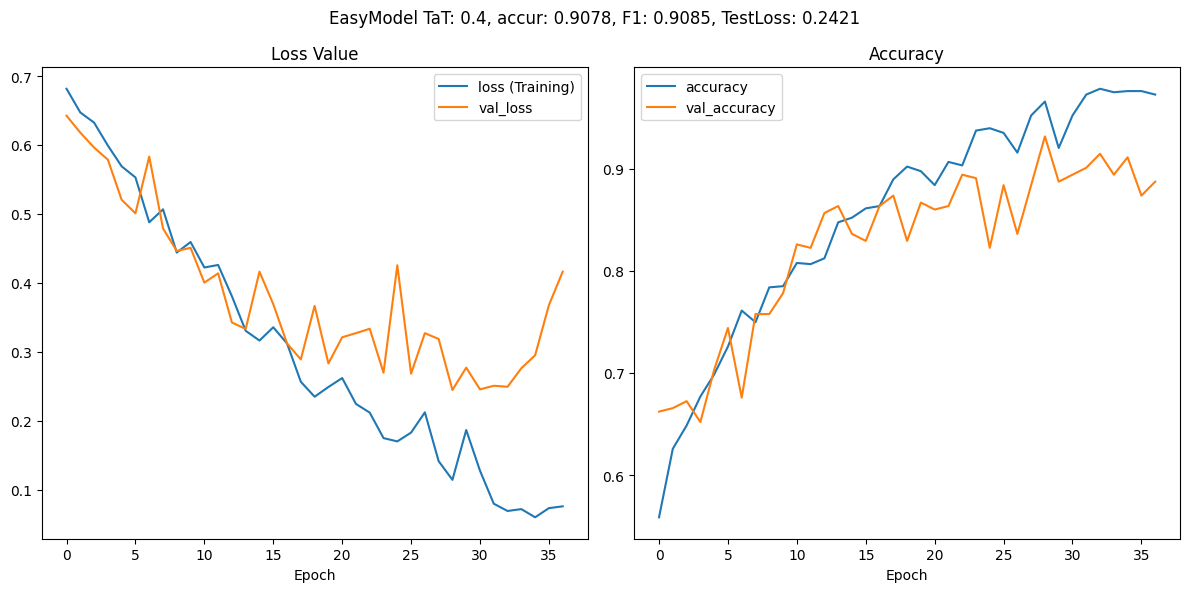

Train loss: 0.07574189454317093
Test val_loss: 0.4161563217639923
Train accuracy: 0.9726962447166443
Accuracy Score: 0.9078498293515358
F1 Score: 0.9084745762711864
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.96      0.91       138
         1.0       0.96      0.86      0.91       155

    accuracy                           0.91       293
   macro avg       0.91      0.91      0.91       293
weighted avg       0.91      0.91      0.91       293



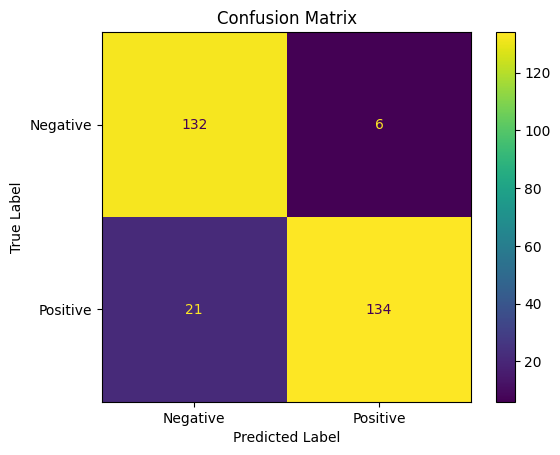

In [26]:
def build_easyModel():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=40, strides=10, activation='relu', input_shape=(WS_B, 4)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=8, strides=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=2, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid')) 

    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)

# Predict labels for test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)

# SEPARATED MODELS F+P

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_467"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_input          │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_52       │ (None, 64)        │    166,912 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_53       │ (None, 32)        │     56,992 │ pose_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 96)        │          0 │ sequential_52[0]… │
│ (Concatenate)       │                   │            │ sequential_53[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 64)        │      6,208 │ concatenate_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 1)         │         65 │ dense_104[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 230,177 (899.13 KB)

 Trainable params: 230,177 (899.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5341 - loss: 0.7004 - val_accuracy: 0.5631 - val_loss: 0.6646
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5600 - loss: 0.6653 - val_accuracy: 0.6177 - val_loss: 0.6871
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6317 - loss: 0.6439 - val_accuracy: 0.6894 - val_loss: 0.6180
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7021 - loss: 0.5921 - val_accuracy: 0.6621 - val_loss: 0.6061
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6747 - loss: 0.5873 - val_accuracy: 0.6519 - val_loss: 0.5647
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7034 - loss: 0.5498 - val_accuracy: 0.6962 - val_loss: 0.5238
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7438 - loss: 0.5023 - val_accuracy: 0.7201 - val_loss: 0.5479
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7801 - loss: 0.4676 - val_accuracy: 0.7747 - val_loss

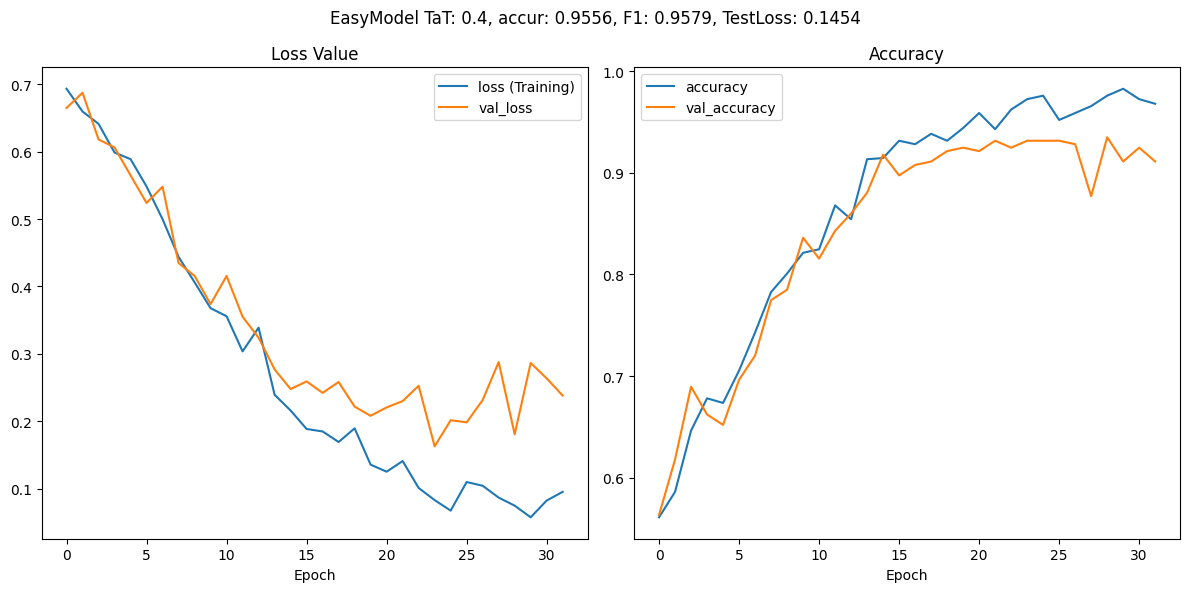

Train loss: 0.09564965218305588
Test val_loss: 0.23825934529304504
Train accuracy: 0.9681456089019775
Accuracy Score: 0.9556313993174061
F1 Score: 0.9579288025889967
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       138
         1.0       0.96      0.95      0.96       155

    accuracy                           0.96       293
   macro avg       0.96      0.96      0.96       293
weighted avg       0.96      0.96      0.96       293



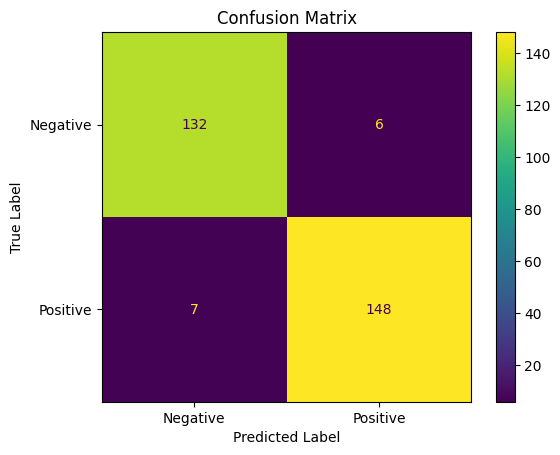

In [27]:
def build_SeparatedEASYmodel(F_input_shape, P_input_shape):
    force_input = Input(shape=F_input_shape, name='force_input')
    Fbranch = Sequential()
    Fbranch.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=F_input_shape))
    Fbranch.add(MaxPooling1D(pool_size=2))
    Fbranch.add(Conv1D(128, kernel_size=10,strides=4, activation='relu'))
    Fbranch.add(MaxPooling1D(pool_size=2))
    Fbranch.add(Conv1D(256, kernel_size=2, activation='relu'))
    Fbranch.add(GlobalMaxPooling1D())
    # Fbranch.add(Flatten())
    Fbranch.add(Dense(64, activation='relu'))
    outF = Fbranch(force_input)

    pose_input = Input(shape=F_input_shape, name='pose_input')
    Pbranch = Sequential()
    Pbranch.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=P_input_shape))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Conv1D(64, kernel_size=10, strides=4, activation='relu'))
    Pbranch.add(GlobalMaxPooling1D())
    # Pbranch.add(Flatten())
    Pbranch.add(Dense(32, activation='relu'))
    outP = Pbranch(pose_input)
    
    merged = concatenate([outF, outP])
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    separated_model = Model(inputs=[force_input, pose_input], outputs=merged)
    
    return separated_model
    
force_input_shape = (WS_B, 1)
pose_input_shape = (WS_B, 3)
model = build_SeparatedEASYmodel(force_input_shape, pose_input_shape)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# SPLITTING DATASET FORCE+POSE
X_force_data = X_data[:, :, :1]
X_pose_data  = X_data[:, :, 1:]

X_train_force,  X_temp_force = train_test_split(X_force_data, test_size=TEST_SIZE, random_state=42)
X_val_force,    X_test_force = train_test_split(X_temp_force , test_size=0.5, random_state=42)

X_train_pose,   X_temp_pose  = train_test_split(X_pose_data, test_size=TEST_SIZE, random_state=42)
X_val_pose,     X_test_pose  = train_test_split(X_temp_pose , test_size=0.5, random_state=42)

X_train = [X_train_force,   X_train_pose]
X_val   = [X_val_force,     X_val_pose]
X_test  = [X_test_force,    X_test_pose]

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])
loss, accuracy = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
    
plot_confusion_matrix(y_test, y_pred_binary)

In [28]:
# model_name = "1D_GRIPA_F+Popt_BranchedEasy94_#2"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_SeparatedEASYmodel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# COMPLEX SEPARATED MODEL

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_493"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_input          │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_54       │ (None, 64)        │    339,072 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_55       │ (None, 64)        │    119,488 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_56       │ (None, 16)        │     63,120 │ pose_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 144)       │          0 │ sequential_54[0]… │
│ (Concatenate)       │                   │            │ sequential_55[0]… │
│                     │                   │            │ sequential_56[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 144)       │          0 │ concatenate_16[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_110 (Dense)   │ (None, 64)        │      9,280 │ dropout_52[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_111 (Dense)   │ (None, 1)         │         65 │ dense_110[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 531,025 (2.03 MB)

 Trainable params: 531,025 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.4596 - loss: 0.7042 - val_accuracy: 0.6416 - val_loss: 0.6591
Epoch 2/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6521 - loss: 0.6403 - val_accuracy: 0.6655 - val_loss: 0.5945
Epoch 3/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6823 - loss: 0.5524 - val_accuracy: 0.7167 - val_loss: 0.4865
Epoch 4/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7357 - loss: 0.4998 - val_accuracy: 0.7747 - val_loss: 0.4775
Epoch 5/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7508 - loss: 0.4932 - val_accuracy: 0.7474 - val_loss: 0.4938
Epoch 6/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7753 - loss: 0.4724 - val_accuracy: 0.7747 - val_loss: 0.4311
Epoch 7/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7588 - loss: 0.4328 - val_accuracy: 0.8055 - val_loss: 0.3844
Epoch 8/44
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7899 - loss: 0.4122 - val_accuracy: 0.7509 -

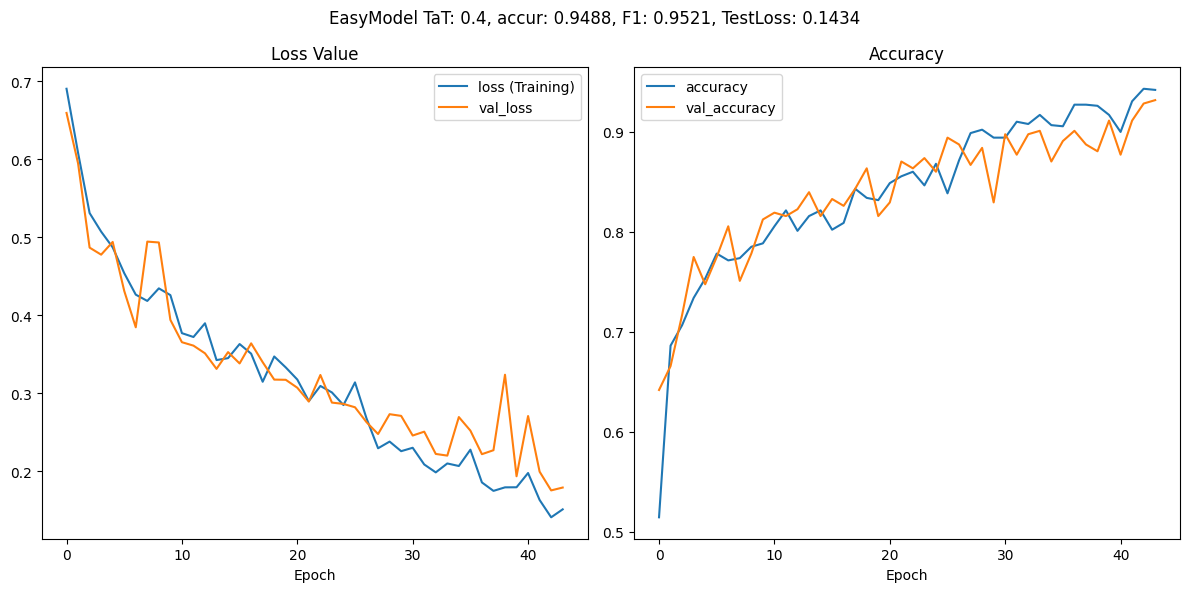

Train loss: 0.15118089318275452
Test val_loss: 0.17913025617599487
Train accuracy: 0.9419795274734497
Accuracy Score: 0.9488054607508533
F1 Score: 0.952076677316294
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       138
         1.0       0.94      0.96      0.95       155

    accuracy                           0.95       293
   macro avg       0.95      0.95      0.95       293
weighted avg       0.95      0.95      0.95       293



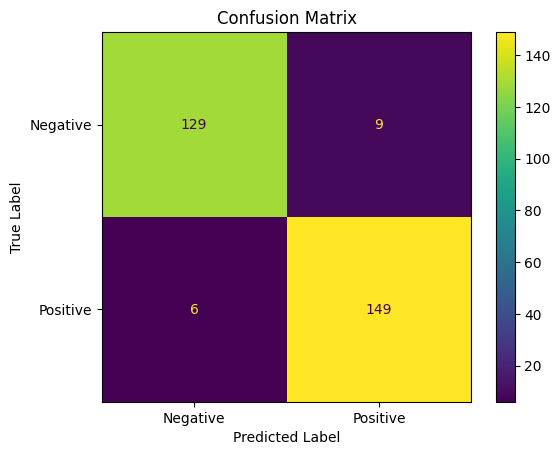

In [29]:
def build_SeparatedEASYmodel(F_input_shape, P_input_shape):
    force_input = Input(shape=F_input_shape, name='force_input')
    Fbranch1 = Sequential()
    Fbranch1.add(Conv1D(64, kernel_size=40, strides=8, activation='relu', input_shape=F_input_shape))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(128, kernel_size=20, strides=2, activation='relu'))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(256, kernel_size=4, activation='relu'))
    Fbranch1.add(GlobalMaxPooling1D())
    Fbranch1.add(Dense(128, activation='relu'))
    Fbranch1.add(Dropout(0.2))
    Fbranch1.add(Dense(64, activation='relu'))
    outF1 = Fbranch1(force_input)

    Fbranch2 = Sequential()
    Fbranch2.add(Conv1D(128, kernel_size=2,  activation='relu', input_shape=F_input_shape))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(64, kernel_size=8, strides=2, activation='relu'))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(128, kernel_size=4, activation='relu'))
    Fbranch2.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch2.add(GlobalMaxPooling1D())
    Fbranch2.add(Dropout(0.1))
    Fbranch2.add(Dense(64, activation='relu'))
    outF2 = Fbranch2(force_input)
    
    pose_input = Input(shape=F_input_shape, name='pose_input')
    Pbranch = Sequential()
    Pbranch.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=P_input_shape))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Conv1D(64, kernel_size=10, activation='relu'))
    Pbranch.add(GlobalMaxPooling1D(pool_size=2))
    # Pbranch.add(Flatten())
    Pbranch.add(Dense(16, activation='relu'))
    outP = Pbranch(pose_input)
    
    merged = concatenate([outF1, outF2, outP])
    merged = Dropout(0.1)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    separated_model = Model(inputs=[force_input, force_input, pose_input], outputs=merged)
    
    return separated_model

force_input_shape = (WS_B, 1)
pose_input_shape = (WS_B, 3)
model = build_SeparatedEASYmodel(force_input_shape, pose_input_shape)
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# SPLITTING DATASET FORCE+POSE
X_force_data = X_data[:, :, :1]
X_pose_data  = X_data[:, :, 1:]

X_train_force,  X_temp_force = train_test_split(X_force_data, test_size=TEST_SIZE, random_state=42)
X_val_force,    X_test_force = train_test_split(X_temp_force , test_size=0.5, random_state=42)

X_train_pose,   X_temp_pose  = train_test_split(X_pose_data, test_size=TEST_SIZE, random_state=42)
X_val_pose,     X_test_pose  = train_test_split(X_temp_pose , test_size=0.5, random_state=42)

X_train = [X_train_force,   X_train_force, X_train_pose]
X_val   = [X_val_force,     X_val_force,   X_val_pose]
X_test  = [X_test_force,    X_test_force,  X_test_pose]

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=44, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])
loss, accuracy = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)
    

In [30]:
# model_name = "1D_GRIPA_F+P_BranchedComplex99_SoGoood"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_SeparatedEASYmodel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# ABOVE MODEL BUT WITH FULL TRAINING

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_519"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_input          │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_57       │ (None, 64)        │    339,072 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_58       │ (None, 64)        │    119,488 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_59       │ (None, 16)        │     63,120 │ pose_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 144)       │          0 │ sequential_57[0]… │
│ (Concatenate)       │                   │            │ sequential_58[0]… │
│                     │                   │            │ sequential_59[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 144)       │          0 │ concatenate_17[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_116 (Dense)   │ (None, 64)        │      9,280 │ dropout_55[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_117 (Dense)   │ (None, 1)         │         65 │ dense_116[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 531,025 (2.03 MB)

 Trainable params: 531,025 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.5493 - loss: 0.6887
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6127 - loss: 0.6324
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6777 - loss: 0.5842
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7408 - loss: 0.5142
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7716 - loss: 0.4543
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8007 - loss: 0.3996
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8499 - loss: 0.3516
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8429 - loss: 0.3482
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8573 - loss: 0.3368
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8501 - loss: 0.3272
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8522 - loss: 0.3051
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accurac

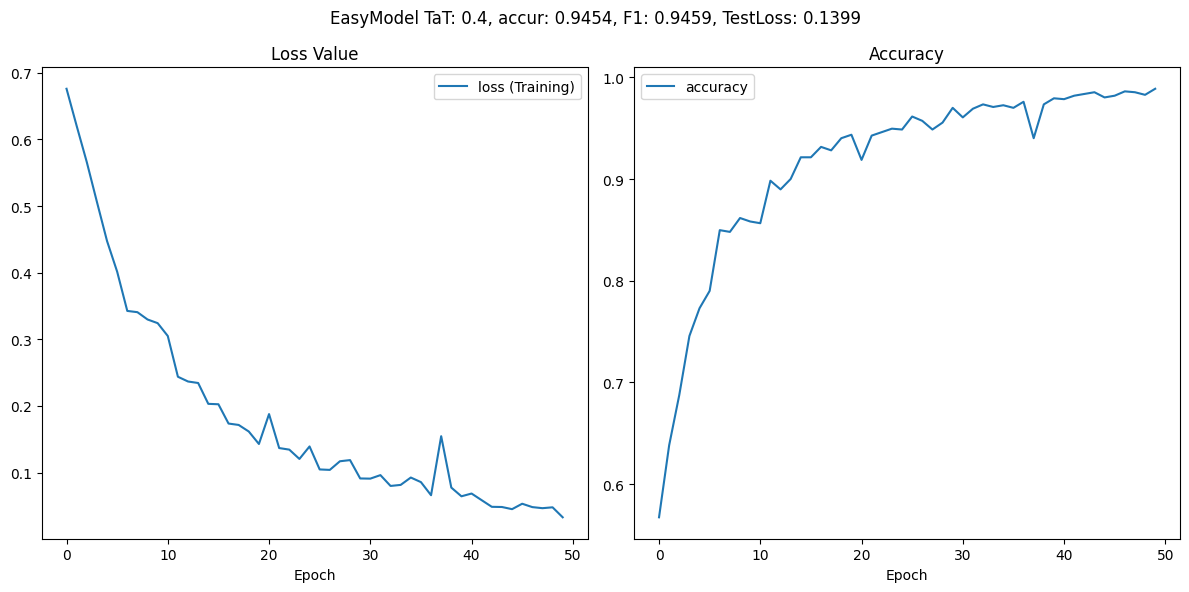

Train loss: 0.0327780619263649
Test loss: 0.13988173007965088
Train accuracy: 0.9889078736305237
Accuracy Score: 0.9453924914675768
F1 Score: 0.9459459459459459
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       150
         1.0       0.92      0.98      0.95       143

    accuracy                           0.95       293
   macro avg       0.95      0.95      0.95       293
weighted avg       0.95      0.95      0.95       293



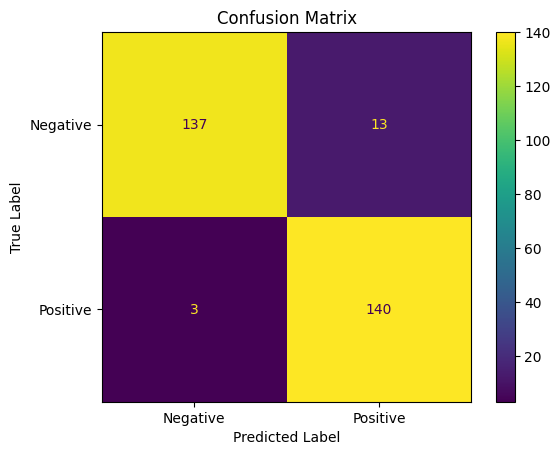

In [31]:
def build_SeparatedEASYmodel(F_input_shape, P_input_shape):
    force_input = Input(shape=F_input_shape, name='force_input')
    Fbranch1 = Sequential()
    Fbranch1.add(Conv1D(64, kernel_size=40, strides=8, activation='relu', input_shape=F_input_shape))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(128, kernel_size=20, strides=2, activation='relu'))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(256, kernel_size=4, activation='relu'))
    Fbranch1.add(GlobalMaxPooling1D())
    Fbranch1.add(Dense(128, activation='relu'))
    Fbranch1.add(Dropout(0.2))
    Fbranch1.add(Dense(64, activation='relu'))
    outF1 = Fbranch1(force_input)

    Fbranch2 = Sequential()
    Fbranch2.add(Conv1D(128, kernel_size=2,  activation='relu', input_shape=F_input_shape))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(64, kernel_size=8, strides=2, activation='relu'))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(128, kernel_size=4, activation='relu'))
    Fbranch2.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch2.add(GlobalMaxPooling1D())
    Fbranch2.add(Dropout(0.1))
    Fbranch2.add(Dense(64, activation='relu'))
    outF2 = Fbranch2(force_input)
    
    pose_input = Input(shape=F_input_shape, name='pose_input')
    Pbranch = Sequential()
    Pbranch.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=P_input_shape))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Conv1D(64, kernel_size=10, activation='relu'))
    Pbranch.add(GlobalMaxPooling1D(pool_size=2))
    # Pbranch.add(Flatten())
    Pbranch.add(Dense(16, activation='relu'))
    outP = Pbranch(pose_input)
    
    merged = concatenate([outF1, outF2, outP])
    merged = Dropout(0.1)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    separated_model = Model(inputs=[force_input, force_input, pose_input], outputs=merged)
    
    return separated_model

force_input_shape = (WS_B, 1)
pose_input_shape = (WS_B, 3)
model = build_SeparatedEASYmodel(force_input_shape, pose_input_shape)
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# SPLITTING DATASET FORCE+POSE
X_force_data = X_data[:, :, :1]
X_pose_data = X_data[:, :, 1:]

# Splitting force data
X_train_force, X_test_force, y_train, y_test = train_test_split(X_force_data, y_data, test_size=0.2, random_state=42)

# Splitting pose data
X_train_pose, X_test_pose, _, _ = train_test_split(X_pose_data, y_data, test_size=0.2, random_state=42)

# Concatenating the labels for the new training dataset
X_train_force_full = X_train_force
X_train_pose_full = X_train_pose

# TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_force_full, X_train_force_full, X_train_pose_full], y_train, epochs=50, batch_size=64, verbose=1, callbacks=[early_stopping])
loss, accuracy = model.evaluate([X_test_force, X_test_force, X_test_pose], y_test)

y_pred = model.predict([X_test_force, X_test_force, X_test_pose])
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test loss:", loss)
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)


In [32]:
# model_name = "1D_GRIPA_F+P_Branched98_Train_NoVal"
# #to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_binary, build_SeparatedEASYmodel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# TRYING TO IMPROVE THE ABOVE MODEL

/home/user/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_554"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ force_input         │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_input          │ (None, 800, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_60       │ (None, 64)        │    339,072 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_61       │ (None, 64)        │    119,488 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_62       │ (None, 64)        │    136,896 │ force_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_63       │ (None, 16)        │     63,120 │ pose_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 208)       │          0 │ sequential_60[0]… │
│ (Concatenate)       │                   │            │ sequential_61[0]… │
│                     │                   │            │ sequential_62[0]… │
│                     │                   │            │ sequential_63[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 208)       │          0 │ concatenate_18[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_123 (Dense)   │ (None, 64)        │     13,376 │ dropout_59[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_124 (Dense)   │ (None, 1)         │         65 │ dense_123[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 672,017 (2.56 MB)

 Trainable params: 672,017 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 258ms/step - accuracy: 0.4978 - loss: 0.6925 - val_accuracy: 0.5495 - val_loss: 0.7045
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6283 - loss: 0.6725 - val_accuracy: 0.6485 - val_loss: 0.6396
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6543 - loss: 0.5872 - val_accuracy: 0.6553 - val_loss: 0.5434
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6927 - loss: 0.5321 - val_accuracy: 0.7235 - val_loss: 0.4938
Epoch 5/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7480 - loss: 0.5028 - val_accuracy: 0.7270 - val_loss: 0.5046
Epoch 6/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7614 - loss: 0.4879 - val_accuracy: 0.8157 - val_loss: 0.4001
Epoch 7/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8186 - loss: 0.3942 - val_accuracy: 0.8396 - val_loss: 0.3248
Epoch 8/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8383 - loss: 0.3388 - val_accuracy: 0.8157 -

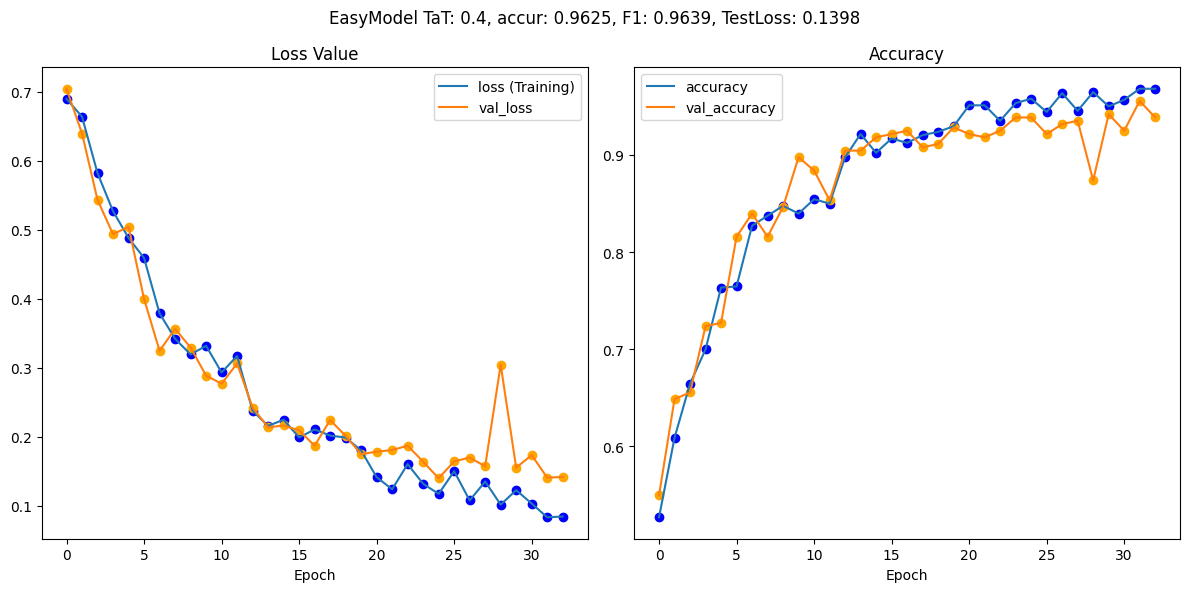

Train loss: 0.08474007248878479
Test val_loss: 0.14206485450267792
Train accuracy: 0.9681456089019775
Accuracy Score: 0.962457337883959
F1 Score: 0.9639344262295082
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       138
         1.0       0.98      0.95      0.96       155

    accuracy                           0.96       293
   macro avg       0.96      0.96      0.96       293
weighted avg       0.96      0.96      0.96       293



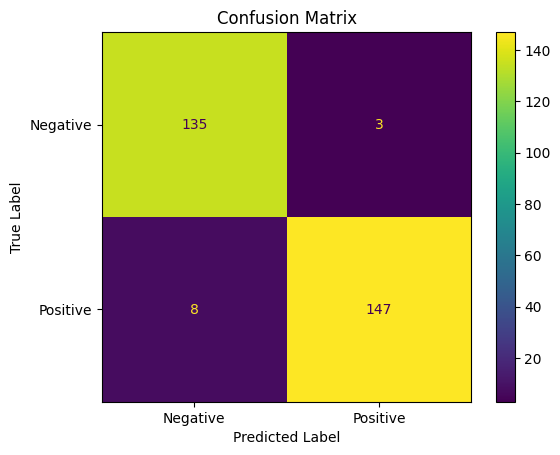

In [33]:
def build_SeparatedEASYmodel(F_input_shape, P_input_shape):
    force_input = Input(shape=F_input_shape, name='force_input')
    Fbranch1 = Sequential()
    Fbranch1.add(Conv1D(64, kernel_size=40, strides=8, activation='relu', input_shape=F_input_shape))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(128, kernel_size=20, strides=2, activation='relu'))
    Fbranch1.add(MaxPooling1D(pool_size=2))
    Fbranch1.add(Conv1D(256, kernel_size=4, activation='relu'))
    Fbranch1.add(GlobalMaxPooling1D())
    Fbranch1.add(Dense(128, activation='relu'))
    Fbranch1.add(Dropout(0.2))
    Fbranch1.add(Dense(64, activation='relu'))
    outF1 = Fbranch1(force_input)

    Fbranch2 = Sequential()
    Fbranch2.add(Conv1D(128, kernel_size=2,  activation='relu', input_shape=F_input_shape))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(64, kernel_size=8, strides=2, activation='relu'))
    Fbranch2.add(MaxPooling1D(pool_size=2))
    Fbranch2.add(Conv1D(128, kernel_size=4, activation='relu'))
    Fbranch2.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch2.add(GlobalMaxPooling1D())
    Fbranch2.add(Dropout(0.1))
    Fbranch2.add(Dense(64, activation='relu'))
    outF2 = Fbranch2(force_input)

    Fbranch3 = Sequential()
    Fbranch3.add(Conv1D(128, kernel_size=10, strides=4,  activation='relu', input_shape=F_input_shape))
    Fbranch3.add(MaxPooling1D(pool_size=2))
    Fbranch3.add(Conv1D(64, kernel_size=4, strides=2, activation='relu'))
    Fbranch3.add(MaxPooling1D(pool_size=2))
    Fbranch3.add(Conv1D(128, kernel_size=10, strides=2, activation='relu'))
    Fbranch3.add(Conv1D(64, kernel_size=2, activation='relu'))
    Fbranch3.add(GlobalMaxPooling1D())
    Fbranch3.add(Dropout(0.1))
    Fbranch3.add(Dense(64, activation='relu'))
    outF3 = Fbranch3(force_input)

    #####################################################################################
    
    pose_input = Input(shape=F_input_shape, name='pose_input')
    Pbranch = Sequential()
    Pbranch.add(Conv1D(64, kernel_size=40, strides=10, activation='relu', input_shape=P_input_shape))
    Pbranch.add(MaxPooling1D(pool_size=2))
    Pbranch.add(Conv1D(64, kernel_size=10, activation='relu'))
    Pbranch.add(MaxPooling1D(pool_size=2))
    # Pbranch.add(Flatten())
    Pbranch.add(Dense(16, activation='relu'))
    outP = Pbranch(pose_input)
    
    merged = concatenate([outF1, outF2, outF3, outP])
    merged = Dropout(0.1)(merged)
    merged = Dense(64, activation='relu')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    separated_model = Model(inputs=[force_input, force_input, force_input, pose_input], outputs=merged)
    
    return separated_model

force_input_shape = (WS_B, 1)
pose_input_shape = (WS_B, 3)

model = build_SeparatedEASYmodel(force_input_shape, pose_input_shape)
model.compile(optimizer=AdamW(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# SPLITTING DATASET FORCE+POSE
X_force_data = X_data[:, :, :1]
X_pose_data  = X_data[:, :, 1:]

X_train_force,  X_temp_force = train_test_split(X_force_data, test_size=TEST_SIZE, random_state=42)
X_val_force,    X_test_force = train_test_split(X_temp_force , test_size=0.5, random_state=42)

X_train_pose,   X_temp_pose  = train_test_split(X_pose_data, test_size=TEST_SIZE, random_state=42)
X_val_pose,     X_test_pose  = train_test_split(X_temp_pose , test_size=0.5, random_state=42)

X_train = [X_train_force,   X_train_force,   X_train_force, X_train_pose]
X_val   = [X_val_force,     X_val_force,     X_val_force,   X_val_pose]
X_test  = [X_test_force,    X_test_force,    X_test_force,  X_test_pose]

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])
loss, accuracy = model.evaluate(X_test, y_test)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].scatter(range(len(history.history["loss"])), history.history["loss"], marker='o', color='blue')
axs[0].scatter(range(len(history.history["val_loss"])), history.history["val_loss"], marker='o', color='orange')
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()
# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].scatter(range(len(history.history["accuracy"])), history.history["accuracy"], marker='o', color='blue')
axs[1].scatter(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], marker='o', color='orange')
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))
plot_confusion_matrix(y_test, y_pred_binary)
    